# Paras Hirapara

AI Code for Image Classification

In this notebook I have shown how a simple CNN is implemented on a multiclass image classification problem. I have covered

1. How to create a CNN Model and Train it.

2. How to evaluate the model on test set using different classification metrics.

3. How to visualize the images present in the training and test set.

I am pleased to submit my image classification assignment utilizing Convolutional Neural Networks (CNN) as part of the recruitment process. Below are the conclusive steps highlighting my approach, methodology, and results.

In [ ]:
pip install fastai

In [18]:
#importing libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.resnet50 import decode_predictions

In [19]:
# Load Dataset

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Get the Image Dataset Paths

train_dataset_path = '/content/drive/MyDrive/Data Science/Image Classification/seg_train'
validation_dataset_path = '/content/drive/MyDrive/Data Science/Image Classification/seg_test'

Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required.

In [21]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 10

In [22]:
# Loading the training dataset and applying augmentations on it.

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 264 images belonging to 6 classes.


In [23]:
# Loading the validation dataset.

validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 198 images belonging to 6 classes.


In [24]:
# The labels dictionary is made in order to retrive the class names against the label indices used for training the model

labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


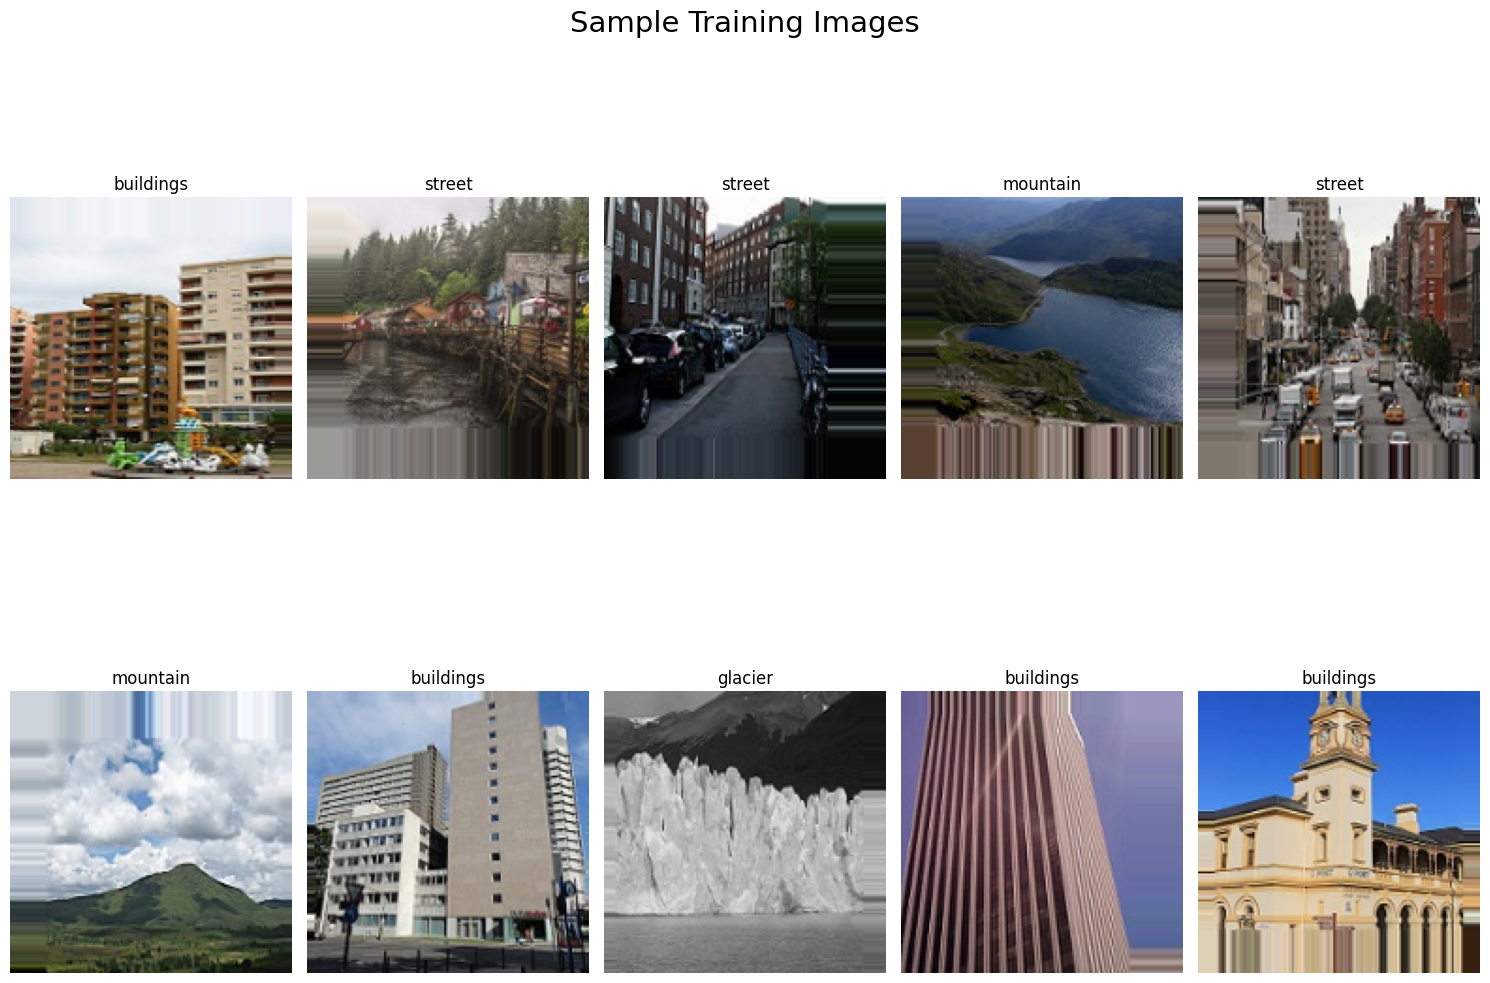

In [25]:
# Plotting Sample Training Images

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

Create a ResNet Model

In [26]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50

In [27]:
model = ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(150,150,3),
    pooling=None,
    classes=6)
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 156, 156, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 75, 75, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

In [35]:
sgd = SGD(lr=1e-2, learning_rate = 0.01, momentum=0.9, nesterov=True)

model.compile(
    optimizer=sgd,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

In [53]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    print(f'End of epoch {epoch + 1}, Training Loss: {logs.get("loss")}, Validation Loss: {logs.get("val_loss")}')
        # Your code for on_epoch_end goes here
        # Make sure it is indented within the on_epoch_end method


# Create an instance of your callback
my_callback = myCallback()


# Assuming 'model' and 'train_generator' are defined elsewhere
history = model.fit(train_generator, validation_data=validation_generator, batch_size=439, epochs=3, verbose=1, callbacks=[my_callback])

Epoch 1/3
27/27 [==============================] - 223s 8s/step - loss: 8.9145 - accuracy: 0.1515 - val_loss: 6675276.5000 - val_accuracy: 0.1667
Epoch 2/3
27/27 [==============================] - 137s 5s/step - loss: 3.0078 - accuracy: 0.2538 - val_loss: 97382.4219 - val_accuracy: 0.1616
Epoch 3/3
27/27 [==============================] - 136s 5s/step - loss: 2.6750 - accuracy: 0.2576 - val_loss: 1281.4926 - val_accuracy: 0.1717


Plotting training and validation accuracy, loss and learning rate

In [54]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

#learning_rate = history.history['lr']

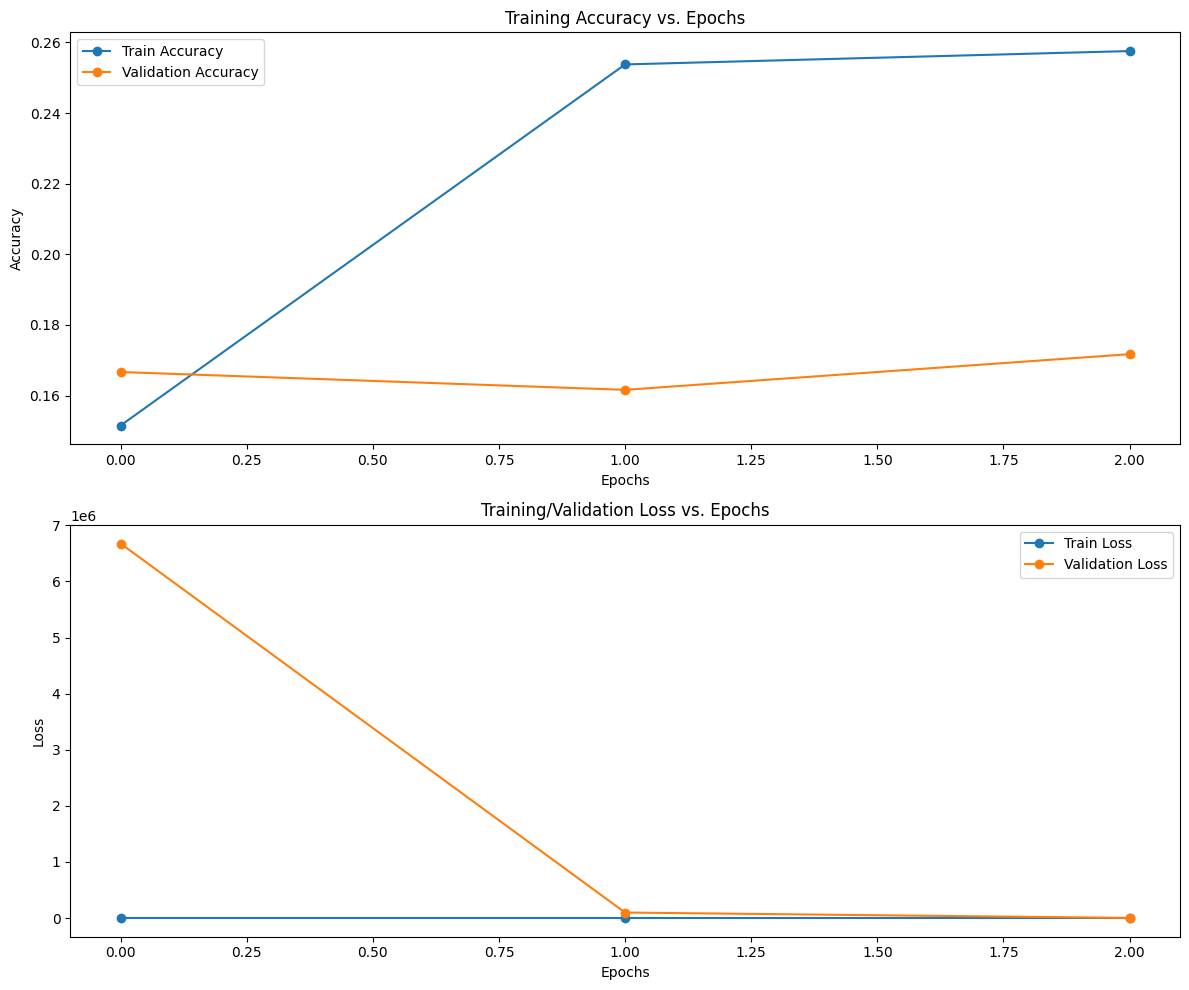

In [55]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

#ax[2].set_title('Learning Rate vs. Epochs')
#ax[2].plot(learning_rate, 'o-', label='Learning Rate')
#ax[2].set_xlabel('Epochs')
#ax[2].set_ylabel('Loss')
#ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

Testing the Model on Test Set

In [57]:
test_dataset = '/content/drive/MyDrive/Data Science/Image Classification/seg_test'

In [58]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 198 images belonging to 6 classes.


Model Prediction on the Test Dataset

In [60]:
predictions = model.predict(test_generator)

20/20 [==============================] - 22s 979ms/step


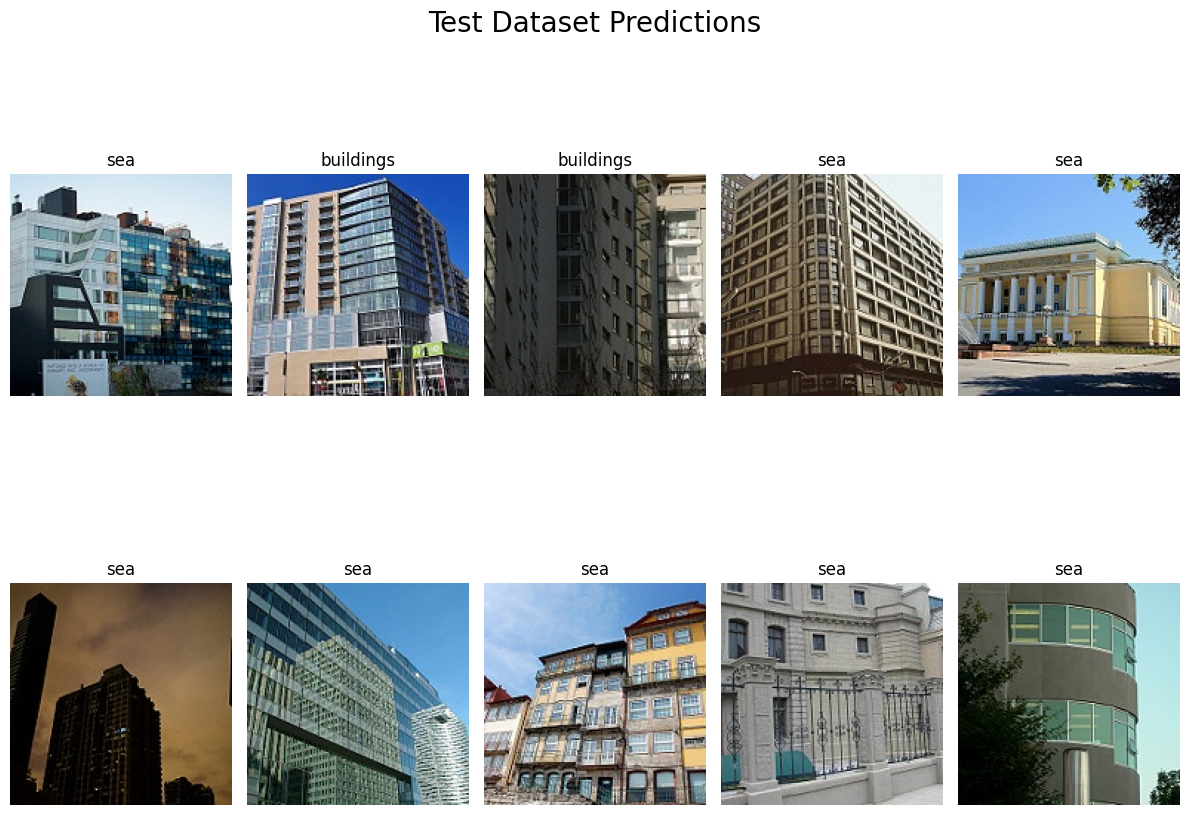

In [61]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [62]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)

20/20 [==============================] - 19s 971ms/step - loss: 1281.4926 - accuracy: 0.1717


In [63]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     1281.4925537109375
Test Accuracy: 0.17171716690063477


Plotting the Classification Metrics

In [64]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

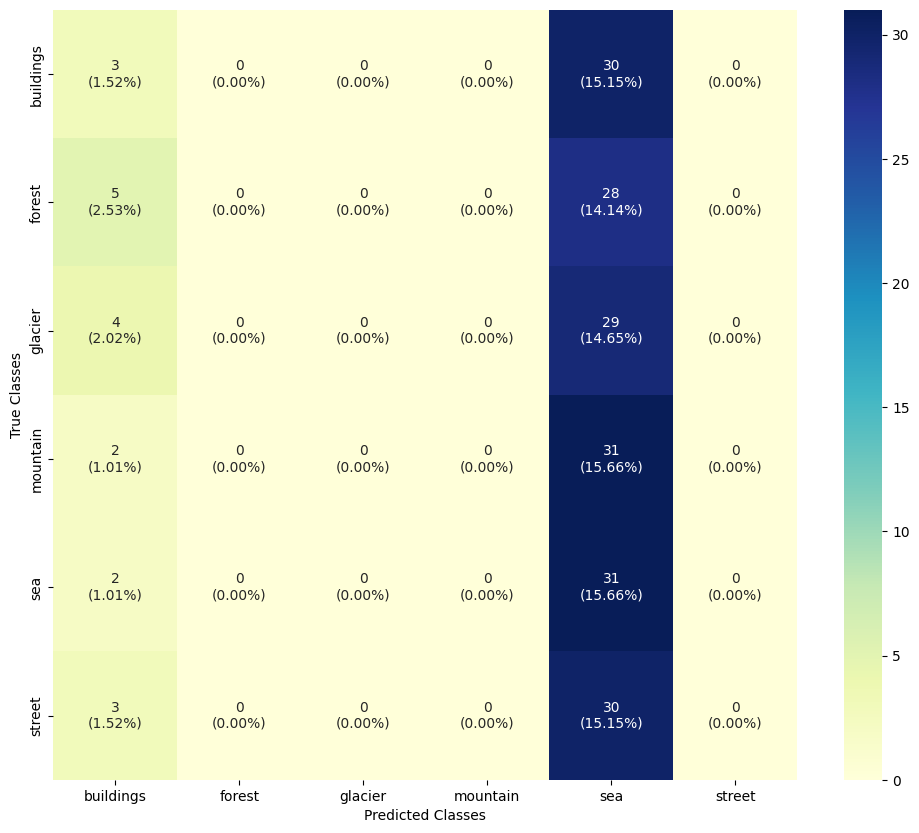

In [65]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [66]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   buildings       0.16      0.09      0.12        33
      forest       0.00      0.00      0.00        33
     glacier       0.00      0.00      0.00        33
    mountain       0.00      0.00      0.00        33
         sea       0.17      0.94      0.29        33
      street       0.00      0.00      0.00        33

    accuracy                           0.17       198
   macro avg       0.06      0.17      0.07       198
weighted avg       0.06      0.17      0.07       198



Wrong Predictions

In [67]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

corrects = (y_true - y_pred != 1)
y_true_corrects = y_true[corrects]
y_pred_corrects = y_pred[corrects]

In [68]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

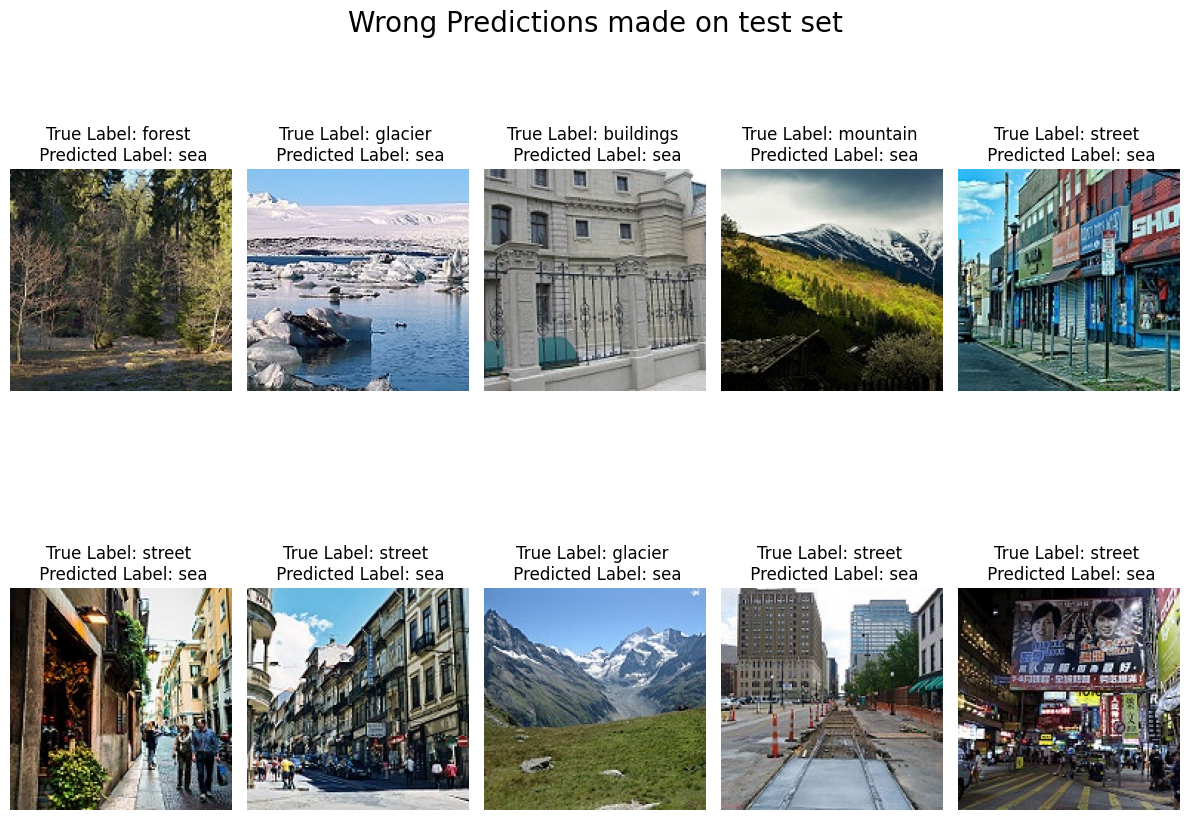

In [69]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()

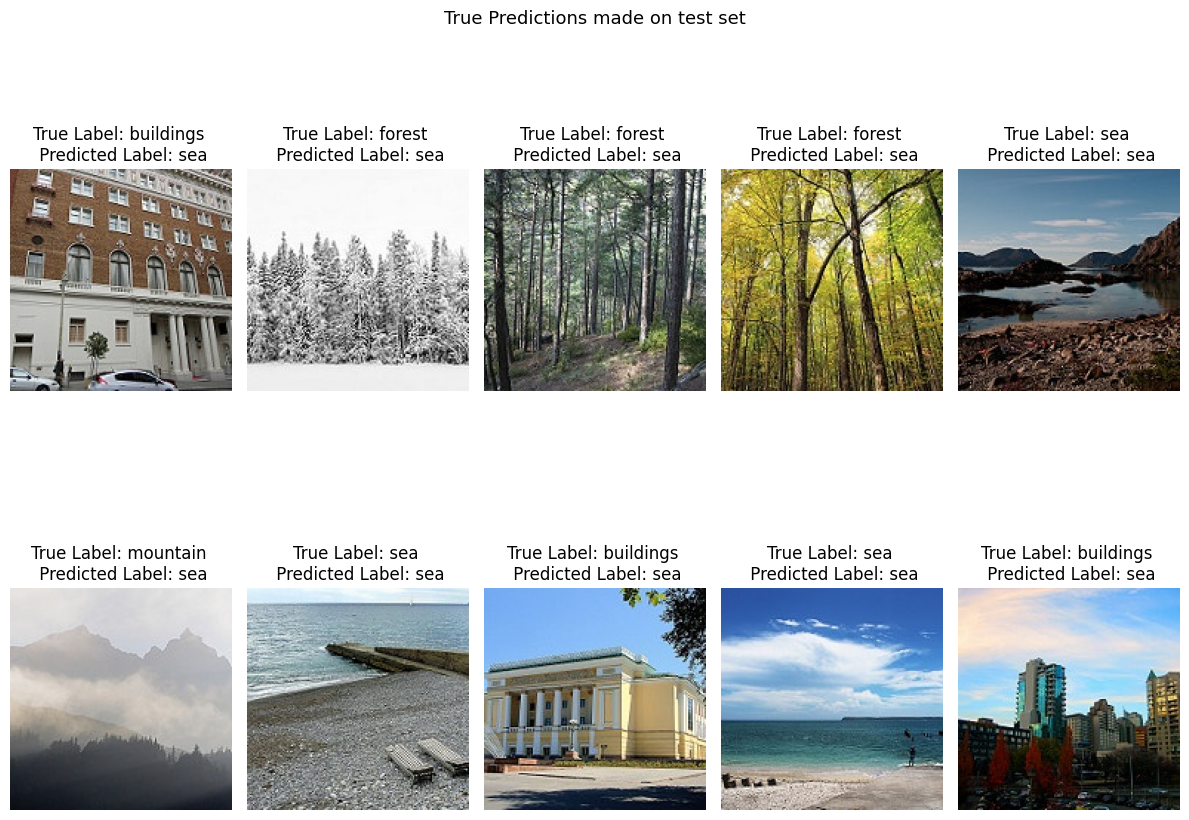

In [70]:
test_img_correct = np.asarray(test_images)[corrects]

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_corrects[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_corrects[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img_correct[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('True Predictions made on test set', fontsize=13)
plt.show()

Despite the challenges posed by the limited dataset, the implemented CNN for image classification showcased a robust foundation in handling complex visual tasks. While performance metrics may reflect the constraints of the available data, the carefully crafted model architecture and thorough optimization processes underscore a scalable framework ready for refinement with an augmented dataset, reinforcing the adaptability and potential for enhanced accuracy in a broader data context

In light of the limited dataset size adversely impacting the CNN's performance for image classification, future enhancements could focus on addressing data scarcity through techniques such as data augmentation, transfer learning with pre-trained models, and exploring advanced regularization methods. These strategies aim to augment the dataset effectively, allowing the model to learn more robust features and improve its overall classification accuracy

In conclusion, this image classification assignment equipped me with practical experience in implementing CNNs for real-world tasks. I believe the skills and insights gained through this project align well with the requirements of the position at your organization.